# Models - Evaluate Student Summaries

## BERT

In [ ]:
#!pip install tensorflow transformers scikit-learn pandas matplotlib

In [1]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

c:\Users\Usuario\Documents\GitHub\NLP-Student-Summaries\env_tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cargar los datos
prompts_df = pd.read_csv('../data/prompts_train.csv')
summaries_df = pd.read_csv('../data/summaries_train.csv')

In [4]:
# Combinar datasets en base a 'prompt_id'
data_df = summaries_df.merge(prompts_df, on="prompt_id")
data_df = data_df[['prompt_text', 'text', 'content', 'wording']]

In [5]:
# Dividir en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

In [6]:
# Inicializar el tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# Función para preparar los datos
def encode_texts(texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

In [8]:
# Combinar 'prompt_text' y 'text' para la entrada y extraer las etiquetas
train_texts = train_df['prompt_text'] + " [SEP] " + train_df['text']
train_targets = train_df[['content', 'wording']].values

test_texts = test_df['prompt_text'] + " [SEP] " + test_df['text']
test_targets = test_df[['content', 'wording']].values

In [9]:
# Tokenizar los textos
train_encodings = encode_texts(train_texts)
test_encodings = encode_texts(test_texts)

In [10]:
# Convertir los targets en tensores de TensorFlow
train_labels = tf.convert_to_tensor(train_targets, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_targets, dtype=tf.float32)

In [11]:
# Cargar el modelo BERT con salida para regresión (2 salidas)
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
            loss='mse',  # Para problemas de regresión
            metrics=['mse'])


In [16]:
# Entrenar el modelo
history = model.fit(
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    train_labels,
    validation_data=(
        {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
        test_labels
    ),
    epochs=3,
    batch_size=8
)

Epoch 1/3


717/717 [==============================] - 3572s 5s/step - loss: 1.0728 - mse: 1.0728 - val_loss: 1.0277 - val_mse: 1.0277
Epoch 2/3
717/717 [==============================] - 3615s 5s/step - loss: 1.0611 - mse: 1.0611 - val_loss: 1.0315 - val_mse: 1.0315
Epoch 3/3
717/717 [==============================] - 6705s 9s/step - loss: 1.0600 - mse: 1.0600 - val_loss: 1.0245 - val_mse: 1.0245


In [19]:
# Guardar el modelo
model.save_pretrained("bert_summary_model")
tokenizer.save_pretrained("bert_summary_model")

('bert_summary_model\\tokenizer_config.json',
 'bert_summary_model\\special_tokens_map.json',
 'bert_summary_model\\vocab.txt',
 'bert_summary_model\\added_tokens.json')

In [24]:
# Evaluar el modelo
eval_results = model.evaluate(
    {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']},
    test_labels
)
print(f"Evaluation Results: {eval_results}")

# Predecir en el conjunto de prueba
predictions = model.predict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']})
pred_labels = predictions.logits

# Calcular el error cuadrático medio (MSE)
mse_content = mean_squared_error(test_targets[:, 0], pred_labels[:, 0])
mse_wording = mean_squared_error(test_targets[:, 1], pred_labels[:, 1])

print(f"Mean Squared Error (Content): {mse_content}")
print(f"Mean Squared Error (Wording): {mse_wording}")

45/45 [==============================] - 225s 5s/step
Mean Squared Error (Content): 1.0938771069779258
Mean Squared Error (Wording): 0.9551091277835091


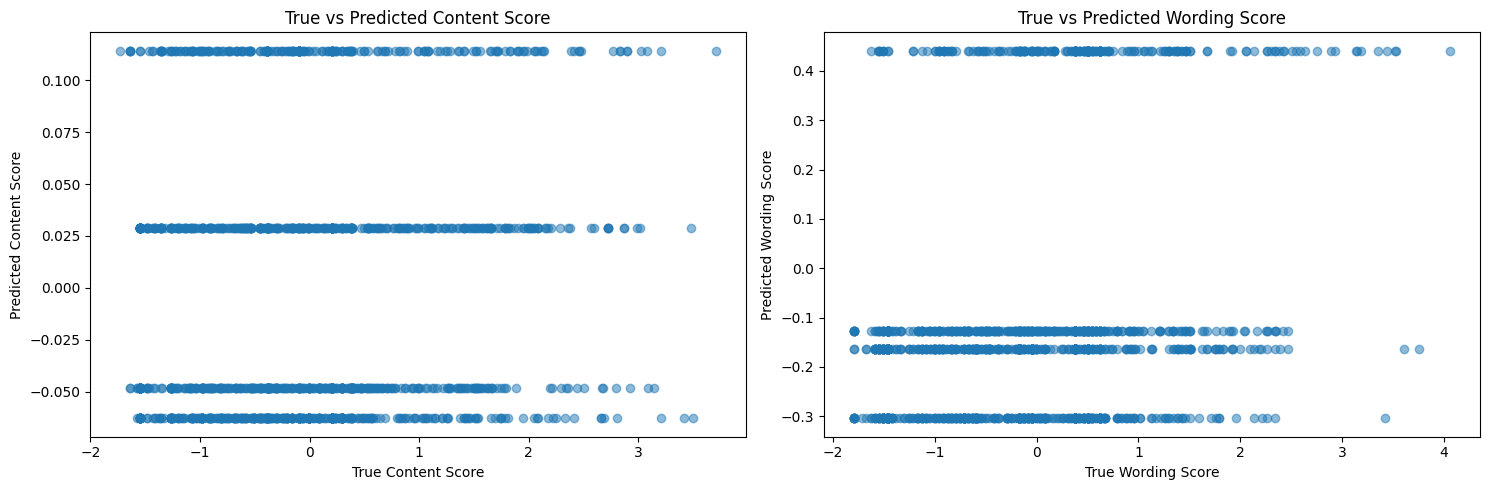

In [25]:
# Visualizar los resultados
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de predicción de contenido
axes[0].scatter(test_targets[:, 0], pred_labels[:, 0], alpha=0.5)
axes[0].set_xlabel("True Content Score")
axes[0].set_ylabel("Predicted Content Score")
axes[0].set_title("True vs Predicted Content Score")

# Gráfico de predicción de redacción
axes[1].scatter(test_targets[:, 1], pred_labels[:, 1], alpha=0.5)
axes[1].set_xlabel("True Wording Score")
axes[1].set_ylabel("Predicted Wording Score")
axes[1].set_title("True vs Predicted Wording Score")

plt.tight_layout()
plt.show()

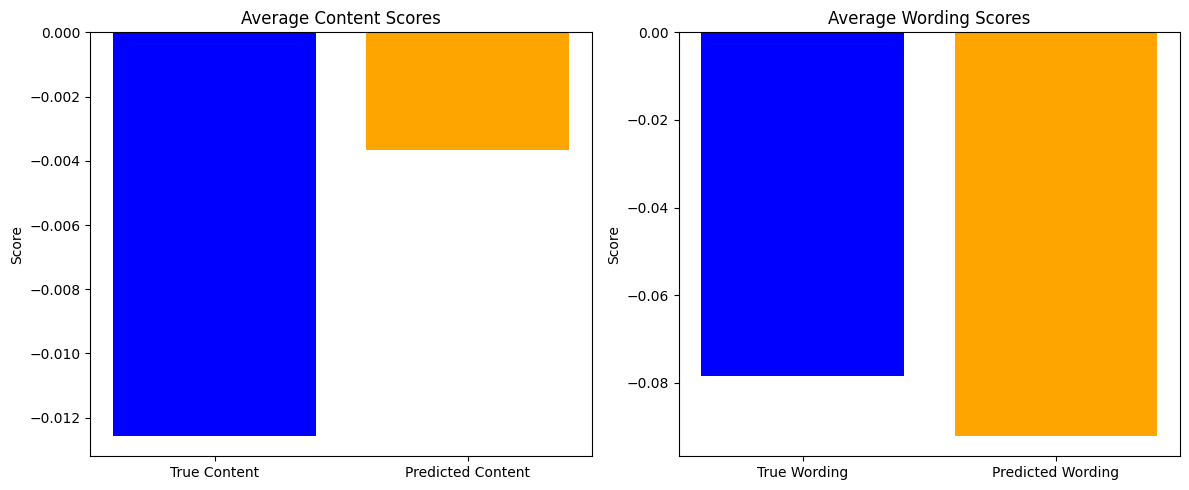

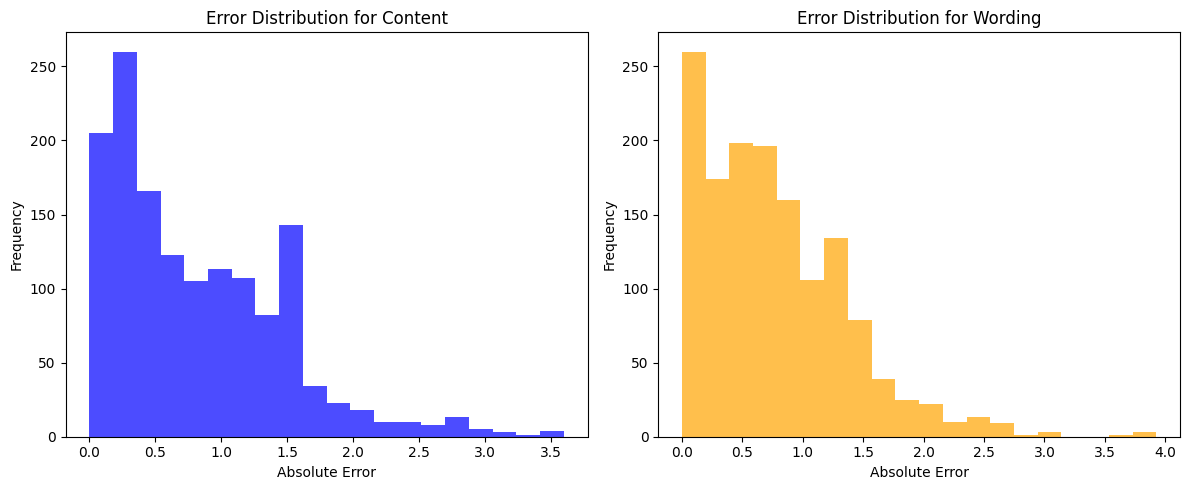

In [26]:
# Calcular los promedios de valores reales y predichos para cada objetivo
avg_true_content = np.mean(test_targets[:, 0])
avg_pred_content = np.mean(pred_labels[:, 0])
avg_true_wording = np.mean(test_targets[:, 1])
avg_pred_wording = np.mean(pred_labels[:, 1])

# Crear gráfico de barras para promedios
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(['True Content', 'Predicted Content'], [avg_true_content, avg_pred_content], color=['blue', 'orange'])
ax[0].set_title("Average Content Scores")
ax[0].set_ylabel("Score")

ax[1].bar(['True Wording', 'Predicted Wording'], [avg_true_wording, avg_pred_wording], color=['blue', 'orange'])
ax[1].set_title("Average Wording Scores")
ax[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

# Calcular los errores absolutos
errors_content = np.abs(test_targets[:, 0] - pred_labels[:, 0])
errors_wording = np.abs(test_targets[:, 1] - pred_labels[:, 1])

# Crear histogramas de errores
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(errors_content, bins=20, color='blue', alpha=0.7)
ax[0].set_title("Error Distribution for Content")
ax[0].set_xlabel("Absolute Error")
ax[0].set_ylabel("Frequency")

ax[1].hist(errors_wording, bins=20, color='orange', alpha=0.7)
ax[1].set_title("Error Distribution for Wording")
ax[1].set_xlabel("Absolute Error")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
